NMT (seq2seq) in fastai v1

Start with this:<br>
https://gist.github.com/ohmeow/fe91aed6267cd779946ab9f10eccdab9

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text import *

# Load data, split, build DataBunch

In [3]:
def seq2seq_pad_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=False, 
                        backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    
    samples = to_data(samples)
    x_max_len = max([len(s[0]) for s in samples])
    y_max_len = max([len(s[1]) for s in samples])
    
    x_res = torch.zeros(len(samples), x_max_len).long() + pad_idx
    y_res = torch.zeros(len(samples), y_max_len).long() + pad_idx
    
    if backwards: pad_first = not pad_first
        
    for i,s in enumerate(samples):
        if pad_first: 
            x_res[i,-len(s[0]):] = LongTensor(s[0])
            y_res[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            x_res[i,:len(s[0]):] = LongTensor(s[0])
            y_res[i,:len(s[1]):] = LongTensor(s[1])
            
    if backwards: res = res.flip(1)
        
    return x_res, y_res

class Seq2SeqDataBunch(DataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, 
               path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1, pad_first=False, 
               device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:        
        """Function that transform the `datasets` in a `DataBunch` for classification.  Passes `**dl_kwargs` on to `DataLoader()`"""
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)
    
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch    

In [4]:
PATH = Path('./data/seq2seq/')
bs = 64

## load the saved data.
data = load_data(PATH, "full_es_en_data_spacyTok.pkl")

In [5]:
b = next(iter(data.train_dl))
b[0].shape, b[1].shape

(torch.Size([64, 255]), torch.Size([64, 252]))

In [6]:
b[0].shape

torch.Size([64, 255])

In [7]:
b[1].shape

torch.Size([64, 252])

In [8]:
len(data.label_list.train.x.vocab.itos), len(data.label_list.train.y.vocab.itos)

(35541, 58838)

In [9]:
len(data.label_list.train.x.vocab.itos), data.label_list.train.vocab.itos[:20]

(35541,
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'the',
  ',',
  '.',
  'of',
  'to',
  'and',
  'in',
  'that',
  'a',
  'is',
  'we'])

# Build a model for Seq2Seq

Big help from this link from the old course + looking at the `Transformer` code and adapting <br>
https://github.com/kheyer/ML-DL-Projects/blob/master/Seq2Seq%20Transformer/Transformer.ipynb

and here:<br>
https://nbviewer.jupyter.org/github/fastai/fastai/blob/6ba17b21599a6fc441794ffd130bc31b5333b4a0/courses/dl2/translate.ipynb



## Build Seq2SeqTransformer

In [10]:
class m_MultiHeadAttention(nn.Module):
    "MutiHeadAttention."
    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0., attn_p:float=0., bias:bool=True,
                 scale:bool=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.att_q = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.att_k = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.att_v = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None, **kwargs):
        "attn -> Linear -> drop -> merge -> LN"
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, k, v, mask=mask, **kwargs))))
    
    def _apply_attention(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        bs,x_len = q.size(0),q.size(1) # bs x bptt x d_model
        wq,wk,wv = self.att_q(q), self.att_k(k), self.att_v(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        attn_score = torch.matmul(wq, wk)
        if self.scale: attn_score.div_(self.d_head ** 0.5)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, x_len, -1)

In [11]:
_activ_func = {Activation.ReLU:nn.ReLU(inplace=True), Activation.GeLU:GeLU(), Activation.Swish: Swish}
def feed_forward(d_model:int, d_ff:int, ff_p:float=0., act:Activation=Activation.ReLU, double_drop:bool=True):
    layers = [nn.Linear(d_model, d_ff), _activ_func[act]]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

class m_EncoderLayer(nn.Module):
    "Basic block of a Transformer model."
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, act:Activation=Activation.ReLU, double_drop:bool=True,
                 attn_cls:Callable=m_MultiHeadAttention):
        super().__init__()
        self.mhra = attn_cls(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=ff_p, act=act, double_drop=double_drop)
    
    def forward(self, x:Tensor, mask:Tensor=None, **kwargs): return self.ff(self.mhra(x, x, x, mask=mask, **kwargs))

class m_DecoderLayer(nn.Module):
    "Decoder block for seq2seq. Self and target attention combined."
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, act:Activation=Activation.ReLU, double_drop:bool=True,
                 attn_cls:Callable=m_MultiHeadAttention):
        super().__init__()
        self.mhra_s    = attn_cls(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.mhra_targ = attn_cls(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=ff_p, act=act, double_drop=double_drop)
        
    def forward(self, x:Tensor, enc_out:Tensor, src_mask:Tensor=None, targ_mask:Tensor=None, **kwargs): 
        x = self.mhra_s(x,x,x, mask=targ_mask, **kwargs)
        return self.ff(self.mhra_targ(x, enc_out, enc_out, mask=src_mask, **kwargs))
    
class Seq2SeqTransformer(nn.Module):
    "Transformer model: https://arxiv.org/abs/1706.03762."
    def __init__(self, vocab_sz:int, tgt_vocab_sz:int, ctx_len:int, n_layers:int, n_heads:int, d_model:int, d_head:int, 
                 d_inner:int, 
                 resid_p:float=0., attn_p:float=0., ff_p:float=0., embed_p:float=0., bias:bool=True, scale:bool=True,
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls:Callable=m_MultiHeadAttention,
                 learned_pos_enc:bool=True, mask:bool=True):
        super().__init__()
        self.mask = mask
        self.encoder = nn.Embedding(vocab_sz, d_model)
        self.pos_enc = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.drop_emb = nn.Dropout(embed_p)

        self.enc_layers = nn.ModuleList([m_EncoderLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                          ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop, 
                          attn_cls=attn_cls) for k in range(n_layers)])

        self.decoder = nn.Embedding(tgt_vocab_sz, d_model)
        self.pos_dec = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.drop_dec = nn.Dropout(embed_p)

        self.dec_layers = nn.ModuleList([m_DecoderLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                          ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop, 
                          attn_cls=attn_cls) for k in range(n_layers)])
        
        self.tgt_word_prj = nn.Linear(d_model, tgt_vocab_sz, bias=False)
        nn.init.xavier_normal_(self.tgt_word_prj.weight)
        self.x_logit_scale = (d_model ** -0.5)
        
    def reset(self):pass
        
    def forward(self, x, y):
        bs, x_len = x.size()
        bs, y_len = y.size()
        pos = torch.arange(0, x_len, device=x.device, dtype=x.dtype)
        inp = self.drop_emb(self.encoder(x) + self.pos_enc(pos)[None]) #.mul_(self.d_model ** 0.5)
        pos_y = torch.arange(0, y_len, device=x.device, dtype=x.dtype)
        targ = self.drop_dec(self.decoder(y) + self.pos_dec(pos_y)[None]) #.mul_(self.d_model ** 0.5)

        ## masking/padding is not yet right here.  Needs to be fixed to mask the pad IDs
        src_mask = (x==1).byte()[:,None,None,:] #[64,5,155,155]
        #mask == trg_mask (but trg_mask also masks out all xxpad ids [id==1]  add that here)
        nopeak_mask = torch.triu(x.new_ones(y_len, y_len), diagonal=1).byte() if self.mask else None
        targ_mask = (y==1).byte()[:,None,:,None] * nopeak_mask
        
        for layer in self.enc_layers: inp  = layer(inp, mask=src_mask)
        for layer in self.dec_layers: targ = layer(targ, inp, src_mask=src_mask, targ_mask=targ_mask)
        decoded = self.tgt_word_prj(targ) * self.x_logit_scale

        return [decoded, decoded, decoded] #for RNN trainer

In [12]:
tfm_seq2seq = Seq2SeqTransformer(vocab_sz=len(data.label_list.train.x.vocab.itos),
                       tgt_vocab_sz=len(data.label_list.train.y.vocab.itos),
                       ctx_len=256, n_layers=3, n_heads=5, d_model=300, d_head=None, d_inner=2048)

In [13]:
def init_transformer(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None: nn.init.normal_(m.weight, 0., 0.02)
        if hasattr(m, 'bias') and m.bias is not None:     nn.init.constant_(m.bias, 0.)
    elif classname.find('LayerNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None: nn.init.normal_(m.weight, 1., 0.02)
        if hasattr(m, 'bias') and m.bias is not None:     nn.init.constant_(m.bias, 0.)

In [14]:
_ = tfm_seq2seq.apply(init_transformer)

In [15]:
@dataclass
class AppendBatchTargs(Callback):
    learn:Learner
    def __init__(self):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target), 'last_target':last_target}

In [ ]:
def seq2seq_loss(input, target):
    '''
    Loss should be different:
    * Remove padding difference of input/output sentence length? (already done in dataset: makes square)
    * Trigger masing with xxbos/xxeos codes?
    '''
    "Loss blanking out anything after xxeos"
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))

In [16]:
learn = LanguageLearner(data, tfm_seq2seq, **{'alpha':0,'beta':0}, callbacks=[AppendBatchTargs()], loss_func=CrossEntropyFlat())
learn.unfreeze()

In [17]:
total_params = sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
f'{total_params:,}'

'56,765,388'

In [18]:
learn.data.batch_size = 16  ## 64 fails to load.  Prob. too big embedding matrix.

In [19]:
## fit one cycle is just too darn agressive for Transformer. Why?
## loss going to nearly zero means we are peaking. How?
learn.fit(25, lr=3e-4)

epoch,train_loss,valid_loss,time
0,0.198410,0.201557,1:05:43
1,0.194250,0.213202,1:06:00
2,0.202427,0.209386,1:06:21
3,0.168224,0.178699,1:05:54
4,0.193883,0.208172,1:05:59
5,0.197498,0.209220,1:05:51
6,0.164671,0.185437,1:05:48
7,0.186331,0.188318,1:05:28
8,0.195042,0.207437,1:06:03
9,0.189739,0.206231,1:06:05


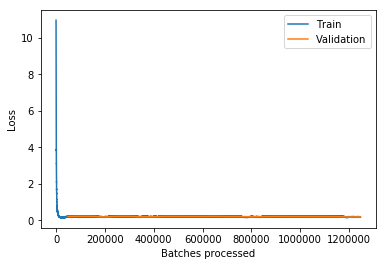

In [20]:
learn.recorder.plot_losses()

In [25]:
x,y = next(iter(learn.data.valid_dl))
preds = learn.model(x,y)
preds[0][0,:].argmax(dim=-1)

tensor([    2,     5,    11,     5,    35,    23,    83,   621,    19,   209,
          486,    10,   724,    10,   820,    10,   952,    10,  1210,    10,
         1414,    10,  1657,    10,  1322,    10,  1471,    10,   985,    10,
         1880,    10,  2167,    10,  2270,    10,  2091,    10,   909,    10,
         1803,    10,  2664,    10,  2780,    10,  1192,    10,  2596,    10,
         4019,    10,  4283,    10,  3091,    10,  3651,    10,  4856,    10,
         4271,    10,  4792,    10,  4964,    10,  3745,    10,  5538,    10,
         5664,    10,  4074,    10,  5296,    10,  5858,    10,  6064,    10,
         6978,    10,  4424,    10,  6428,    10,  6963,    10,  6632,    10,
         7383,    10,  8393,    10,  2530,    10,  5315,    10,  4053,    10,
         7715,    10,  2282,    10,  7931,    10, 10684,    10,  5890,    10,
         8345,    10,  2640,    10,  7729,    10,  6045,    10,  7007,    10,
         8048,    10,  3974,    10,  5856,    10,  6467,    10, 

In [22]:
x_itos = data.label_list.train.x.vocab.itos
y_itos = data.label_list.train.y.vocab.itos

In [54]:
i = 0
for i in range(5):
    print(' '.join([x_itos[o] for o in x[i,:] if o != 1]))
    print(' '.join([y_itos[o] for o in y[i,:] if o != 1]))
    print(' '.join([y_itos[o] for o in preds[0][i,:].argmax(dim=1) if o!=1]))
    print()

xxbos xxmaj the xxmaj commission can not accept amendments 1 , 2 , 3 , 5 , 6 , 7 , 9 , 12 , 13 , 15 , 17 , 22 , 23 , 24 , 25 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 35 , 37 , 38 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 51 , 52 , 54 , 55 , 56 , 57 , 58 , 66 , 69 , 70 , 71 , 75 , 77 , 80 , 82 , 84 , 85 , 86 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 98 , 99 , 100 , 106 , 109 , 110 , 111 , 112 , 113 , 114 , 118 , 129 , 131 , 133 , 134 , 135 , 136 , 137 , 138 , 143 , 150 , 151 , 152 , 153 , 154 , 155 , 156 , 160 , 162 , 164 , 166 , 167 , 168 , 169 , 170 , 173 , 174 , 177 , 178 , 179 , 182 , 189 , 206 , 212 , 214 , 216 , 218 , 219 , 222 , 223 , 224 , 225 , 226 , 227 , 228 , 229 , 230 , 231 , 232 , 233 , 234 , 237 , 238 , 239 , 240 ,
xxbos xxmaj la xxmaj comisión no puede aceptar las enmiendas 1 , 2 , 3 , 5 , 6 , 7 , 9 , 12 , 13 , 15 , 17 , 22 , 23 , 24 , 25 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 35 , 37 , 38 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 51 , 52 , 54 , 55 , 56 , 57 , 58 , 66 , 69 , 70 , 7

In [ ]:
## need to separate encoder/decoder parts.
### Tranaslation will be:
# * Set state from src sentence in encoder (torch.no_grad() to keep state?)
# * start with xxbos token
# * proceed through each step with next word (example below)
# * OR:  beam_search() to get best set of next words up to end.  

In [61]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encoder(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decoder(Variable(ys), memory, src_mask, Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = F.softmax(model.out(out[:, -1]))
        #_, next_word = torch.max(prob, dim = 1)
        next_word = torch.multinomial(prob, 1)
        next_word = next_word.data[0][0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [52]:
ys = greedy_decode(m, src[10].unsqueeze(0), src_mask[10], enlen_90, 0)

xxbos 2 , 4 , 6 , 7 , 10 , 11 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 25 , 27 , 28 , 30 , 33 , 35 , 36 , 37 , 38 , 41 , 42 , 43 , 44 , 45 , 49 , 50 , 56 , 57 , 59 , 60 , 61 , 64 , 69 , 72 , 75 , 77 , 78 , 79 , 82 , 83 , 84 , 85 , 92 , 98 , 100 , 104 , 107 , 108 , 109 , 112 , 113 , 115 , 118 , 119 , 121 , 122 , 123 , 124 , 126 , 127 , 128 , 131 , 132 , 133 , 134 , 135 , 140 , 145 , 147 , 148 , 149 , 153 , 155 , 156 , 157 , 158 , 163 , 166 , 167 , 168 , 178 , 179 , 180 , 182 , 183 , 186 , 187 , 188 , 191 , 197 , 201 , 202 , 203 , 205 , 206 , 208 , 209 , 210 , 211 , 212 , 213 , 214 and 215 .


In [62]:
learn.model

Seq2SeqTransformer(
  (encoder): Embedding(35541, 300)
  (pos_enc): Embedding(256, 300)
  (drop_emb): Dropout(p=0.0)
  (enc_layers): ModuleList(
    (0): m_EncoderLayer(
      (mhra): m_MultiHeadAttention(
        (att_q): Linear(in_features=300, out_features=300, bias=True)
        (att_k): Linear(in_features=300, out_features=300, bias=True)
        (att_v): Linear(in_features=300, out_features=300, bias=True)
        (out): Linear(in_features=300, out_features=300, bias=True)
        (drop_att): Dropout(p=0.0)
        (drop_res): Dropout(p=0.0)
        (ln): LayerNorm(torch.Size([300]), eps=1e-05, elementwise_affine=True)
      )
      (ff): SequentialEx(
        (layers): ModuleList(
          (0): Linear(in_features=300, out_features=2048, bias=True)
          (1): ReLU(inplace)
          (2): Dropout(p=0.0)
          (3): Linear(in_features=2048, out_features=300, bias=True)
          (4): Dropout(p=0.0)
          (5): MergeLayer()
          (6): LayerNorm(torch.Size([300]), eps=

In [24]:
## can we use this encoder as a LM for english??